In [1]:
import os 
import pandas as pd
import numpy as np

# import sklearn methods 
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
import sys 
from sklearn.model_selection import learning_curve
from sklearn.datasets import make_classification
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
# display test scores and return result string and indexes of false samples
def display_test_scores(test, pred):
    str_out = ""
    str_out += ("TEST SCORES\n")
    str_out += ("\n")

    #print accuracy
    accuracy = accuracy_score(test, pred)
    str_out += ("ACCURACY: {:.4f}\n".format(accuracy))
    str_out += ("\n")
    
    #print confusion matrix
    str_out += ("CONFUSION MATRIX:\n")
    conf_mat = confusion_matrix(test, pred)
    str_out += ("{}".format(conf_mat))
    str_out += ("\n")
    str_out += ("\n")

    #print FP, FN
    str_out += ("FALSE POSITIVES:\n")
    fp = conf_mat[1][0]
    pos_labels = conf_mat[1][0]+conf_mat[1][1]
    str_out += ("{} out of {} positive labels ({:.4f}%)\n".format(fp, pos_labels,fp/pos_labels))
    str_out += ("\n")

    str_out += ("FALSE NEGATIVES:\n")
    fn = conf_mat[0][1]
    neg_labels = conf_mat[0][1]+conf_mat[0][0]
    str_out += ("{} out of {} negative labels ({:.4f}%)\n".format(fn, neg_labels, fn/neg_labels))
    str_out += ("\n")

    
    #print classification report
    str_out += ("PRECISION, RECALL, F1 scores:\n")
    str_out += ("{}".format(classification_report(test, pred)))
    
    false_indexes = np.where(test != pred)
    return str_out, false_indexes

# MERGED DATA

The best parameters are {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'reg_lambda': 10} with a score of 0.7317
TEST SCORES

ACCURACY: 0.7314

CONFUSION MATRIX:
[[196164  14647  38898]
 [ 41029 120494  36797]
 [ 43701  19129 212157]]

FALSE POSITIVES:
41029 out of 161523 positive labels (0.2540%)

FALSE NEGATIVES:
14647 out of 210811 negative labels (0.0695%)

PRECISION, RECALL, F1 scores:
              precision    recall  f1-score   support

           0       0.70      0.79      0.74    249709
           1       0.78      0.61      0.68    198320
           2       0.74      0.77      0.75    274987

    accuracy                           0.73    723016
   macro avg       0.74      0.72      0.73    723016
weighted avg       0.74      0.73      0.73    723016



([<matplotlib.patches.Wedge at 0x7f7b249895d0>,
 [Text(-0.36984061597417733, 1.0359623153261133, 'n_EAR'),
  Text(-1.0999704459046618, 0.008063382435401853, 'n_MAR'),
  Text(-0.1951711486698092, -1.082547099542051, 'n_MOE'),
  Text(0.5101926417524311, -0.9745273050570086, 'n_EC'),
  Text(1.0888631161802664, -0.15613172074309528, 'n_LEB'),
  Text(0.7852032085928021, 0.7703609032236569, 'n_SOP'),
  Text(0.40184109381581196, 1.0239744798191566, 'PERCLOS'),
  Text(0.03506354795234204, 1.0994410159735692, 'CLOSENESS')],
 [Text(-0.20173124507682397, 0.5650703538142435, '10.91%'),
  Text(-0.599983879584361, 0.004398208601128283, '27.94%'),
  Text(-0.10645699018353227, -0.5904802361138459, '16.62%'),
  Text(0.27828689550132596, -0.5315603482129136, '4.41%'),
  Text(0.5939253360983271, -0.08516275676896105, '25.70%'),
  Text(0.4282926592324375, 0.4201968563038128, '3.53%'),
  Text(0.21918605117226103, 0.5585315344468126, '9.87%'),
  Text(0.019125571610368385, 0.5996950996219468, '1.01%')])

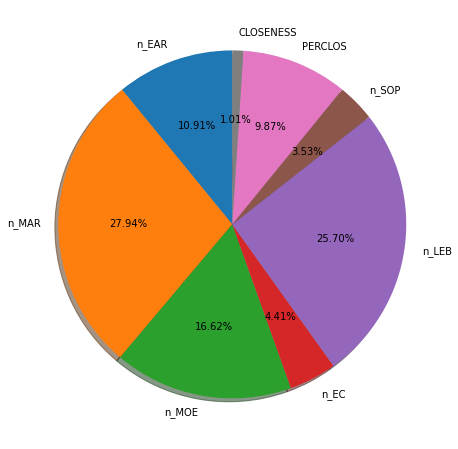

In [3]:
df_original = pd.read_pickle('../input/rlddandmerged/merged_normalized_scaled.pkl')

X = df_original.loc[:, ["n_EAR", 
                    "n_MAR", "n_MOE", "n_EC",
                    "n_LEB", "n_SOP", "PERCLOS", "CLOSENESS"]]

y = df_original.loc[:, "DROWSINESS"].map({0: 0, 0.5: 1, 1:2})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# cross-validation with 5 splits
cross_val = StratifiedShuffleSplit(n_splits=10, random_state = 42)

lgb_estimator = lgb.LGBMClassifier(random_state = 0,device= "gpu")

# parameters 
parameters = {  
                'reg_lambda': [0.1, 1, 10],
                'n_estimators': [300],
                'max_depth': [5, 10],
                'learning_rate':[0.001, 0.01, 0.1]
                }

# grid search for parameters
grid = GridSearchCV(estimator=lgb_estimator, param_grid=parameters, cv=cross_val, n_jobs=-1)#multithreading; all cores are used
grid.fit(X_train, y_train)

# print best scores
print("The best parameters are %s with a score of %0.4f"
      % (grid.best_params_, grid.best_score_))

# prediction results
y_pred = grid.predict(X_test)

# print accuracy metrics
results, false = display_test_scores(y_test, y_pred)
print(results)

# plot importances
labels = X_train.columns
plt.figure(figsize=(8,8))
plt.pie(grid.best_estimator_.feature_importances_, labels=labels, shadow=True, startangle=90, autopct='%1.2f%%') 